### Load Dependencies

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import sys

sys.path.append("..")
from ecg_dataset import ECGDataset

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### Load Dataset

In [ ]:
dataset = ECGDataset("../data/preprocessed_beats.npy")
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

### Define the Auto Encoder Model

In [49]:
import torch.nn as nn
import torch

class ECG_AE(nn.Module):
    def __init__(self, input_length=360):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),   # [B, 16, 180]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),  # [B, 32, 90]
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),  # [B, 64, 45]
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 90]
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # [B, 16, 180]
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),   # [B, 1, 360]
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

### Training Loop

In [42]:
model = ECG_AE().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
train_losses, val_losses = [], []
best_loss = float('inf')
best_model_path = "../weights/ae_model_best.pth"

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f} - Test Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Saved new best model (test loss: {best_loss:.4f})")


Epoch 1/20 - Train Loss: 0.5549 - Val Loss: 0.4437
✓ Saved new best model (val loss: 0.4437)
Epoch 2/20 - Train Loss: 0.1204 - Val Loss: 0.0304
✓ Saved new best model (val loss: 0.0304)
Epoch 3/20 - Train Loss: 0.0230 - Val Loss: 0.0181
✓ Saved new best model (val loss: 0.0181)
Epoch 4/20 - Train Loss: 0.0156 - Val Loss: 0.0139
✓ Saved new best model (val loss: 0.0139)
Epoch 5/20 - Train Loss: 0.0123 - Val Loss: 0.0112
✓ Saved new best model (val loss: 0.0112)
Epoch 6/20 - Train Loss: 0.0104 - Val Loss: 0.0090
✓ Saved new best model (val loss: 0.0090)
Epoch 7/20 - Train Loss: 0.0081 - Val Loss: 0.0075
✓ Saved new best model (val loss: 0.0075)
Epoch 8/20 - Train Loss: 0.0074 - Val Loss: 0.0064
✓ Saved new best model (val loss: 0.0064)
Epoch 9/20 - Train Loss: 0.0059 - Val Loss: 0.0056
✓ Saved new best model (val loss: 0.0056)
Epoch 10/20 - Train Loss: 0.0052 - Val Loss: 0.0050
✓ Saved new best model (val loss: 0.0050)
Epoch 11/20 - Train Loss: 0.0049 - Val Loss: 0.0046
✓ Saved new best 

### Plot Losses

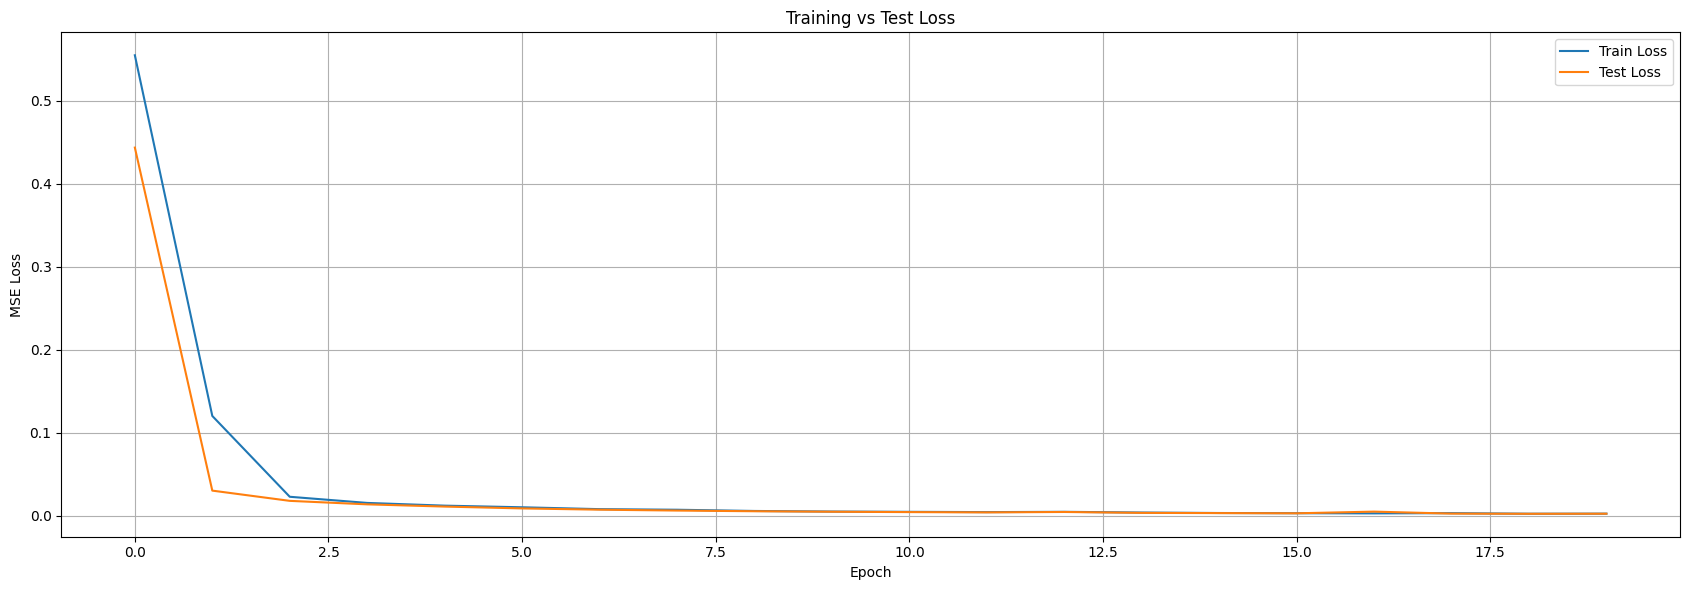

In [47]:
plt.figure(figsize=(17, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Test Loss")
plt.title("Training vs Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualize Reconstructions

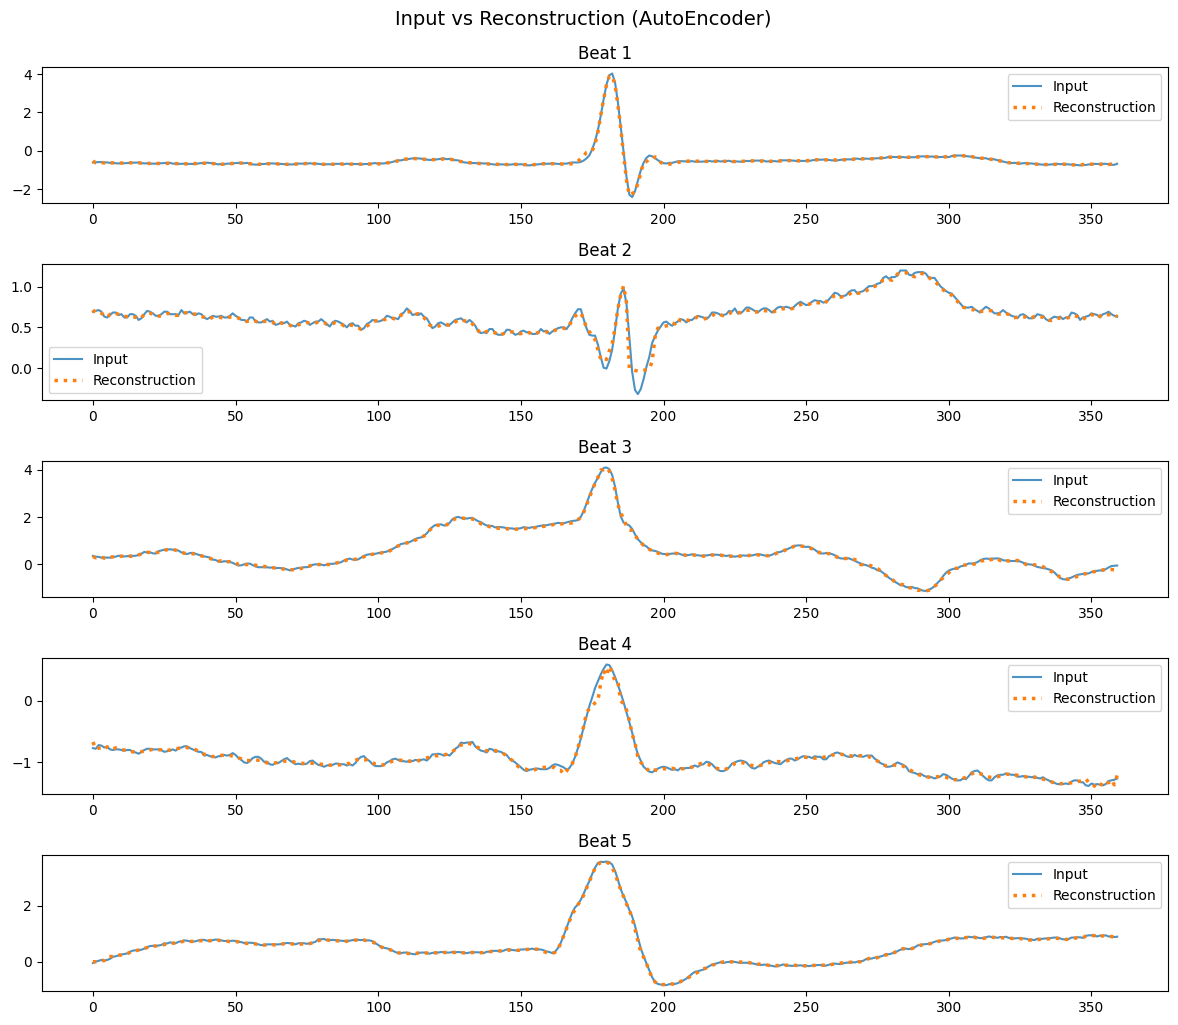

In [48]:
model.eval()
with torch.no_grad():
    batch = next(iter(test_loader)).to(device)
    recon = model(batch).cpu().numpy()
    batch = batch.cpu().numpy()

# Plot each beat and its reconstruction in separate subplots
plt.figure(figsize=(12, 10))
for i in range(5):
    plt.subplot(5, 1, i + 1)
    plt.plot(batch[i, 0], label="Input", alpha=0.8)
    plt.plot(recon[i, 0], label="Reconstruction", linestyle=":", linewidth=2.5)
    plt.title(f"Beat {i+1}")
    plt.legend()
    plt.tight_layout()

plt.suptitle("Input vs Reconstruction (AutoEncoder)", fontsize=14, y=1.02)
plt.show()
